# Example Overview

During late June 2019, I deployed a profiler at the OOI Oregon Shelf site from the R/V Elakha. A combination of platform malfunction (51%) and operator error (49%) caused the profiler to profile at 20 minute intervals instead of the program defined 12 hours. This resulted in a very high resolution dataset that has largely gone unnoticed, but I think tells an interesting story. Exploring this data could turn into a neat project for a student or NSF REU intern.


This deployment was the 13th profiler deployment at the OOI CE02SHSP (CE02SHSP-00013). It was deployed on June 24th 2019 at around 0930 Pacific Time. Unfortunately, the profiler did not surface during the expected testing period. Conveniently, the profilers are equipped with an acoustic transducer, and I was able convince the profiler to resurface using a portable transducer placed over the side. We considered the deployment a success and then that evening used the acoustic transducer on the nearby OOI CE02SHSM mooring to verify that the profiler was operating as expected. A day later, something somewhere went wrong and the autonomous profiler decided, arguably on its own, to revert back to the original command of profiling every 20 minutes and then to stop communicated both over cellular network and acoustically.





## Custom Environment

It is recommended that you create a custom environment so that your installed packages will persist between server resets.

1. Move to the user directory. `cd ~`
2. Create custom named environment with a python version of choosing. `conda create -n myooi python=3.11`
3. Activate the new environment. `conda activate myooi`
4. Install required packages.
    - `cd ~`
    - `git clone https://github.com/IanTBlack/ooijh.git`
    - `cd ooijh`
    - `pip install -r requirements.txt`
    - `pip install .`
    - `pip install ipykernel ipympl`
5. Create a UI button for your custom environment.
    - `python -m ipykernel install --user --name myooi --distplay-name "Python (myooi)"`

## Processing Steps Overview

For each individual data file...
1. Import the file. 
2. Swap the `obs` dimension to be the `time` dimension.
3. Then drop the `obs` variable along with other OOI system variables (e.g. `ingestion_timestamp`)
4. Drop OOI custom QC test variables. The has been indication that the OOI will adhere more to the QARTOD variants in the future ([Palevsky et al, 2023](https://repository.oceanbestpractices.org/bitstream/handle/11329/2112/OOI%20Biogeochemical%20Sensor%20Data%20Best%20Practices%20and%20User%20Guide.pdf?sequence=1&isAllowed=y)).
5. Obtain latitude and longitude of the dataset and assign as a new variable for secondary computations like absolute salinity.
6. Exclude data if the primary QARTOD flag marked it as fail (flag = 4) or missing (flag = 9).
7. For OPTAA data (Sea-Bird ACS), the factory calibration, temperature-salinity, and scattering correction are applied along with interpolationt to 1nm bins.

Then each datasets is merged and duplicate values are dropped. This is to ensure that the most complete time-series is obtained without having to worry about the data transmission method (e.g. telemetered in near-real time or recovered from the host computer).

After each data are merged...
1. Compute additional data products (e.g. absolute salinity, conservative temperature, particulate organic carbon, chlorophyll-a from absorption).
2. Identify individual profiles and bin into 0.5 meter bins.
3. Find the upper and lower 25\% gradient depths similar to the methods of [Benoit-Bird et al, 2009](https://aslopubs.onlinelibrary.wiley.com/doi/epdf/10.4319/lo.2009.54.4.1382)
4. Find the 1\% light level for each profile.

## Step 0.0: Setup

In [1]:
from datetime import datetime
from itertools import repeat
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import multiprocessing
import pandas as pd
import numpy as np
import requests
import re
import os
import xarray as xr

from ooijh import CTD, FLORT, DOSTA, PARAD, VELPT

## Step 0.1: Definitions

We are interested in the `CE02SHSP` platform. The OOIJH package I have been developing will allow you to use partial representations of the site, node, instrument, and stream to identify the data of interest. Instead of `SP001`, you can use `SP` to define the data of interest. We can also seek files be time rather than deployment. I have also created custom classes for most of the OOI sensors which will 

In [2]:
site = 'CE02SHSP'
node = 'SP'
bdt = datetime(2019,6,25)
edt = datetime(2019,6,28)

ctd = CTD(site, node, begin_datetime = bdt, end_datetime = edt)
flort = FLORT(site, node, begin_datetime = bdt, end_datetime = edt)
dosta = DOSTA(site, node, begin_datetime = bdt, end_datetime = edt)
parad = PARAD(site, node, begin_datetime = bdt, end_datetime = edt)
velpt = VELPT(site, node, begin_datetime = bdt, end_datetime = edt)

## Step 1.0: Obtaining Data
The `.get_data()` function is a wrapper for the steps outlined in the processing steps overview described previously. It contains code that is pertinent to the sensor of interest. 

In [3]:
%%time
ctdds = ctd.get_data()
flods = flort.get_data()
dosds = dosta.get_data()
pards = parad.get_data()
velds = velpt.get_data()

CPU times: user 1.43 s, sys: 5.15 s, total: 6.58 s
Wall time: 10.5 s


## Reorganizing Data For Individual Profile Binning
By default, OOI CSPP datasets have a `depth` dimension. It is important to note that this does not indicate that the dataset is binned by depth. When using Xarray, repeated values in the `depth` dimension may throw errors when attempting to do additional processing, so one possible solution is to reassign depth as a variable since it is only connected to time if we inspect the dataset.

In [4]:
d = ctdds.depth.values
ctdds = ctdds.drop_vars(['depth'])
ctdds['depth'] = (['time'], d)

In [5]:
d = flods.depth.values
flods = flods.drop_vars(['depth','pressure'])
flods['depth'] = (['time'], d) 

In [6]:
d = dosds.depth.values
dosds = dosds.drop_vars(['depth','pressure'])
dosds['depth'] = (['time'], d) 

In [7]:
d = pards.depth.values
pards = pards.drop_vars(['depth','pressure'])
pards['depth'] = (['time'], d) 

In [8]:
d = velds.depth.values
velds = velds.drop_vars(['depth','pressure'])
velds['depth'] = (['time'], d) 

## Combining Datasets and Binning By Profile
Sometimes when you bin profiler data, you may receive a different number of profile bins between datasets because of the . One work-around is to combine each dataset. If there are conflicting timestamps and depths, then we will default to using the depth associated with the CTD.

In [9]:
# Thanks to Chris Wingard at the OOI Endurance Array for this code that creates profiles.

def split_profiles(ds):
    """
    Split the data set into individual profiles, where each profile is a
    collection of data from a single deployment and profile sequence. The
    resulting data sets are returned in a list.

    :param ds: data set containing the profile data
    :return: a list of data sets, one for each profile
    """
    # split the data into profiles, assuming at least 120 seconds between profiles
    dt = ds.where(ds['time'].diff('time') > np.timedelta64(120, 's'), drop=True).get_index('time')

    # process each profile, adding the results to a list of profiles
    profiles = []
    jback = np.timedelta64(30, 's')  # 30 second jump back to avoid collecting data from the following profile
    for i, d in enumerate(dt):
        # pull out the profile
        if i == 0:
            profile = ds.sel(time=slice(ds['time'].values[0], d - jback))
        else:
            profile = ds.sel(time=slice(dt[i - 1], d - jback))

        # add the profile to the list
        profiles.append(profile)

    # grab the last profile and append it to the list
    profile = ds.sel(time=slice(d, ds['time'].values[-1]))
    profiles.append(profile)
    return profiles

def bin_profile(profile, ds_min_depth, ds_max_depth, medfilt = 5):
    min_depth = int(ds_min_depth/0.25) * 0.25 - 0.25
    max_depth = int(ds_max_depth/0.25) * 0.25 + 0.25
    bins = np.arange(min_depth, max_depth, 0.5)
    labels = (bins + 0.25)[:-1]
    
    medfilt1 = profile.rolling(time=medfilt, min_periods=1, center=True).median(keep_attrs=True,skipna = True).dropna(dim = 'time',subset = ['deployment'])
    medfilt2 = medfilt1.rolling(time=medfilt, min_periods=1, center=True).median(keep_attrs=True,skipna = True).dropna(dim = 'time',subset = ['deployment'])
    binned_profile = medfilt2.groupby_bins('depth', bins,labels = labels).mean(skipna = True)
    binned_profile = binned_profile.assign_coords({'time': [profile.time.min().values]})
    return binned_profile

def bin_profiles(_ds, medfilt = 5):
    min_depth = _ds.depth.min().values
    max_depth = _ds.depth.max().values
    profiles = split_profiles(_ds)
    binned_profiles = []
    for profile in profiles:
        binned_profiles.append(bin_profile(profile, min_depth, max_depth,medfilt = medfilt))
    binned_profiles = [v for v in binned_profiles if v is not None]
    pds = xr.combine_by_coords(binned_profiles)
    return pds

In [10]:
proctd = bin_profiles(ctdds)
proctd['time'] = proctd.time - pd.Timedelta(hours = 7)

In [11]:
provel = bin_profiles(velds)
provel['time'] = provel.time - pd.Timedelta(hours = 7)

In [12]:
proflo = bin_profiles(flods)
proflo['time'] = proflo.time - pd.Timedelta(hours = 7)

depths = []
lowdepths = []
peaks = []
for _time in proflo.time.values:
    pro = proflo.sel(time = _time)
    peak_val = pro.fluorometric_chlorophyll_a.max()
    peakd = pro.where(pro.fluorometric_chlorophyll_a == peak_val, drop = True)
    try:
        peakdepth = peakd.sel(depth_bins == peakd.depth_bins.max()).depth_bins.mean()
    except:
        peakdepth = peakd.depth_bins.max().values
    
    upper_pro = pro.sel(depth_bins = slice(0, peakdepth))
    lower_pro = pro.sel(depth_bins = slice(peakdepth, 80))
    try:
        upper_thresh = upper_pro.where(upper_pro.fluorometric_chlorophyll_a <= peak_val * 0.10, drop = True)
        upper_depth = upper_thresh.depth_bins.max().values
    except:
        upper_depth = 0
        
    try:
        lower_thresh = lower_pro.where(lower_pro.fluorometric_chlorophyll_a <= peak_val * 0.10, drop = True)
        lower_depth = lower_thresh.depth_bins.min().values
    except:
        lower_depth = 80
    
    lowdepths.append(lower_depth)
    depths.append(upper_depth)
    peaks.append(peakdepth)
proflo['upper_gradient_depth'] = (['time'],depths)
proflo['peak_depth'] = (['time'],peaks)
proflo['lower_gradient_depth'] = (['time'], lowdepths)

proflo['upper_gradient_depth'] = proflo.upper_gradient_depth.rolling(time = 6, center = True, min_periods = 1).median()
proflo['peak_depth'] = proflo.peak_depth.rolling(time = 6, center = True, min_periods = 1).median()
proflo['lower_gradient_depth'] = proflo.lower_gradient_depth.rolling(time = 6, center = True, min_periods = 1).median()


In [13]:
propar = bin_profiles(pards)
propar['time'] = propar.time - pd.Timedelta(hours = 7)


sensor_noise = propar.parad_j_par_counts_output.quantile([0.01])

propar['parad_j_par_counts_output'] = propar.parad_j_par_counts_output - sensor_noise
propar['parad_j_par_counts_output'] = propar.parad_j_par_counts_output.where(propar.parad_j_par_counts_output > 0, 0)

# Compute euphotic zone depth by calculating 1% of the maximum value observed in the top 5 meters.
surf = propar.sel(depth_bins = slice(0.5,5))[['parad_j_par_counts_output']]
surf = surf.max(dim = 'depth_bins')
parq = surf.parad_j_par_counts_output * 0.01
depths = []
for _time in propar.time.values:
    pro = propar.sel(time = _time)
    pq = parq.sel(time = _time)
    if pq == 0:
        depths.append(0)
        continue
    d = pro.where(pro.parad_j_par_counts_output >= pq, drop = True)
    try:
        depths.append(d.depth_bins.values.max())
    except:
        depths.append(0)
propar['euphotic_depth'] = (['time'],depths)    

propar = propar.sel(quantile = 0.01)
propar['euphotic_depth'] = propar.euphotic_depth.rolling(time = 3, center = True, min_periods = 1).max()

## Plotting Data

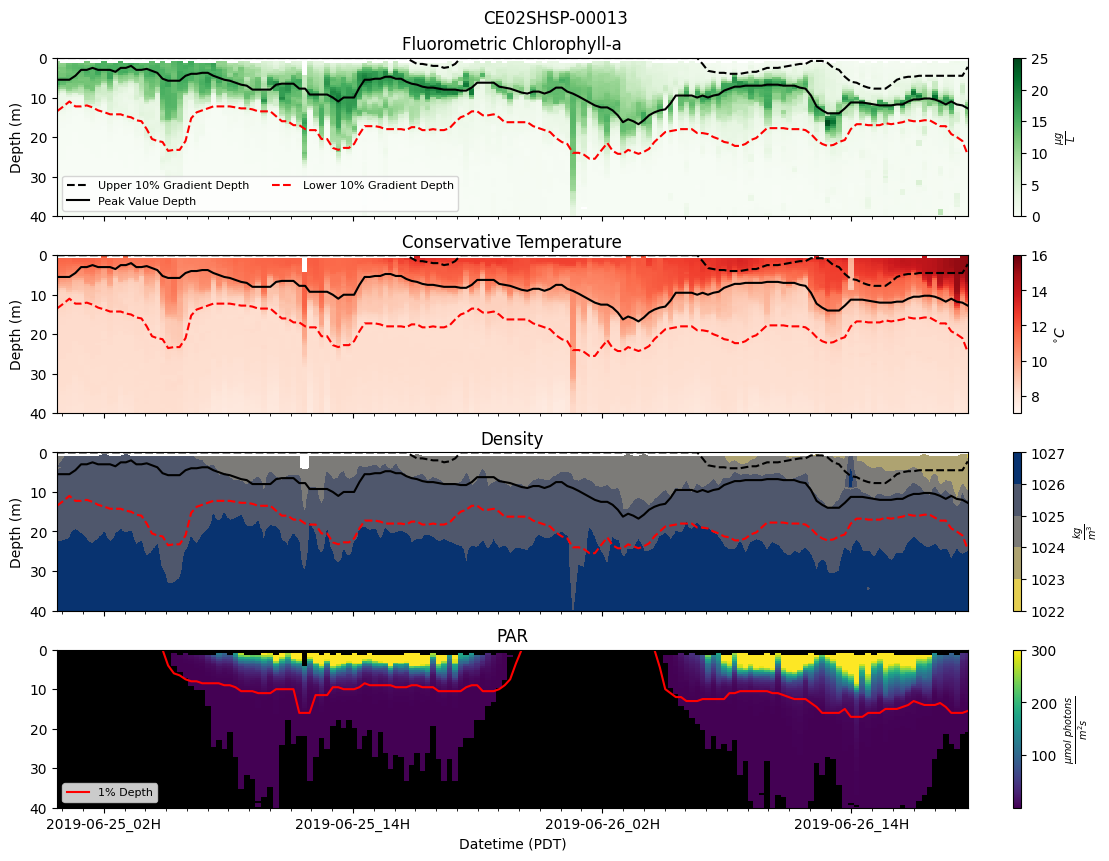

In [14]:
num_plots = 4
fig, ax = plt.subplots(num_plots,1, figsize = (11,8.5), constrained_layout = True,sharex = True, sharey = True)

_ax = 0
ax[_ax].set_title('Fluorometric Chlorophyll-a')
y,x = np.meshgrid(proflo.depth_bins,proflo.time)
z = proflo.fluorometric_chlorophyll_a
p = ax[_ax].pcolormesh(x,y,z, cmap = 'Greens', vmin = 0, vmax = 25)
fig.colorbar(p, ax = ax[_ax], label = r'$\frac{{\mu}g}{L}$')
             
      
_ax = 1
ax[_ax].set_title('Conservative Temperature')
y,x = np.meshgrid(proctd.depth_bins,proctd.time)
z = proctd.sea_water_conservative_temperature
p = ax[_ax].pcolormesh(x,y,z, cmap = 'Reds', vmin = 7, vmax = 16)
fig.colorbar(p, ax = ax[_ax], label =  r'$^{\circ}C$')
             
    
    
_ax = 2
ax[_ax].set_title('Density')
y,x = np.meshgrid(proctd.depth_bins,proctd.time)
z = proctd.sea_water_density
levels = range(1022, 1028)
p = ax[_ax].contourf(x,y,z, cmap = 'cividis_r',levels = levels)
fig.colorbar(p, ax = ax[_ax], label =  r'$\frac{kg}{m^3}$')
             
        
_ax = 3
ax[_ax].set_title('PAR')
par_cmap = matplotlib.colormaps['viridis']
par_cmap.set_under('black')
y,x = np.meshgrid(propar.depth_bins,propar.time)
z = propar.parad_j_par_counts_output
p = ax[_ax ].pcolormesh(x,y,z,cmap = par_cmap, vmin = 0.03, vmax = 300)
fig.colorbar(p, ax = ax[_ax ], label = r'$\frac{{\mu}mol\ photons}{m^2s}$')
ax[_ax].plot(propar.time, propar.euphotic_depth, color = 'red', label = '1% Depth')
ax[_ax].legend(loc = 'lower left', fontsize = 8)

            
             
for i in range(num_plots):
    if i == 3:
        continue
    ax[i].plot(proflo.time, proflo.upper_gradient_depth, color = 'black', linestyle = '--', label = 'Upper 10% Gradient Depth')
    ax[i].plot(proflo.time, proflo.peak_depth, color = 'black', label = 'Peak Value Depth')
    ax[i].plot(proflo.time, proflo.lower_gradient_depth, color = 'red',linestyle = '--' ,label = 'Lower 10% Gradient Depth')
    ax[i].set_ylabel('Depth (m)')
    
ax[0].legend(loc = 'lower left', ncol = 2,fontsize = 8)
ax[-1].set_ylim(0,40)
ax[-1].invert_yaxis()
ax[-1].xaxis.set_minor_locator(mdates.HourLocator(interval = 1))
ax[-1].xaxis.set_major_locator(mdates.HourLocator([2,14]))
ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d_%HH'))
ax[-1].set_xlabel('Datetime (PDT)')
fig.suptitle('CE02SHSP-00013')


plt.savefig('/home/jovyan/ooi_example.jpg', dpi = 600)